### SINGLE NEURON SYSTEM ###

## definizamo il modello ##

useremo il modello Hodgkin-Huxley.

# variabili #
- V: potenziale di membrana
- m,h,n: variabili di gating che regolano la probabilità di apertura dei canali

# costanti #
- Cm: capacità della membrana
- GNa: massima conduttanza dei canali di sodio
- GK: massima conduttanza dei canali di potassio
- GL: massima conduttanza dei canali leak
- ENa: potenziale inverso per il sodio (V di equilibrio per il flusso di sodio attraverso la membrana)
- EK: potenziale inverso per il potassio (V di equilibrio per il flusso di potassio attraverso la membrana)
- EL: potenziale inverso per i canali leak (V di equilibrio per il flusso di leak attraverso la membrana) 
- Iext: inpulso di corrente esterno lo considero una funzione del tempo

# funzioni del modello #
dV_dt = Iext-INa(V)-IK(V,n)-IL(V) / Cm                                     
dn_dt = n_inf(V) - n / tau_n

# funzini ausiliarie #
alpha_m(V) = (0.1*(25-V))/(e^((25-v)/10)-1)           beta_m = 4*e^(-V/18)                  
alpha_n(V) = (0.1*(10-V))/(e^((10-v)/10)-1)           beta_n = 0.125*e^(-V/80) 
aplha_h(V) = 0.07*e^(-V/20)                           beta_h = 1/(1+e^((30-V)/10))

n_inf = alpha_n(V)/(alpha_n(V) + beta_n(V))  n_inf = 1 / (1 + e^(-(V - V_mid_n)/k_n))               
m_inf = alpha_m(V)/(alpha_m(V) + beta_m(V))  m_inf = 1 / (1 + e^(-(V - V_mid_m)/k_m))              
Tau_n = 1/(alpha_n(V) + beta_n(V))

INa = GNa * m_inf(V) * (V - ENa)         
IK = GK * n * (V - EK)            
IL = GL * (V - EL)

# calcolo degli equilibri #
per trovare gli equilibri devo trovare i punti nelle quali le derivate si annullano contemporaneamente.
risolvendo il sistema troverò gli equilibri

funzioni per il plot temporale e di fase

In [109]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve
import itertools as it

In [183]:
def alpha_m(v): return np.where(np.abs(25 - v) < 1e-9, 1.0, (0.1 * (25 - v)) / (np.exp(np.clip((25 - v) / 10, -700, 700)) - 1))
def alpha_h(v): return 0.07 * np.exp(np.clip(-v / 20, -700, 700))
def alpha_n(v): return np.where(np.abs(10 - v) < 1e-9, 0.1, (0.01 * (10 - v)) / (np.exp(np.clip((10 - v) / 10, -700, 700)) - 1))

def beta_m(v): return 4 * np.exp(np.clip(-v / 18, -700, 700))
def beta_h(v): return 1 / (1 + np.exp(np.clip((30 - v) / 10, -700, 700)))
def beta_n(v): return 0.125 * np.exp(np.clip(-v / 80, -700, 700))

def m_inf(V): return alpha_m(V) / (alpha_m(V) + beta_m(V))
def h_inf(V): return alpha_h(V) / (alpha_h(V) + beta_h(V))
def n_inf(V): return alpha_n(V) / (alpha_n(V) + beta_n(V))

def I_Na(V,m,h,g_Na,ENa): return g_Na * m**3 * h * (V - ENa)
def I_K(V,n,g_K,Ek): return g_K * n**4 * (V - Ek)
def I_L(V,g_L,El): return g_L * (V - El)

def Id(t,Ie):
    if isinstance(Ie,list):
        return sum(valore * (t_start <= t < t_start + durata) for valore, t_start, durata in Ie)
    else:
        return Ie

def neuron(t,y,Cm,GNa,Gk,Gl,ENa,Ek,El,Ie):
    V,m,h,n= y
    dV_dt = (Id(t,Ie)-I_Na(V,m,h,GNa,ENa)-I_K(V,n,Gk,Ek)-I_L(V,Gl,El))/Cm
    dm_dt = alpha_m(V)*(1-m)-beta_m(V)*m
    dh_dt = alpha_h(V)*(1-h)-beta_h(V)*h
    dn_dt = alpha_n(V)*(1-n)-beta_n(V)*n
    return [dV_dt, dm_dt, dh_dt, dn_dt]

def system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    t_span = (0,T)
    t_eval = np.linspace(0,T,n_p)
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    y0 = [V0,m0,h0,n0]
    return solve_ivp(neuron, t_span, y0, args=(Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie),t_eval = t_eval)

def find_eqs_ponts(V0,Cm,GNa,ENa,Gk,Ek,Gl,El,Ie):
    def eq_equations(y0,Cm,GNa,ENa,Gk,Ek,Gl,El,Ie):
        V,m,h,n = y0
        dV_dt = (Ie-I_Na(V,m,h,GNa,ENa)-I_K(V,n,Gk,Ek)-I_L(V,Gl,El))/Cm
        dm_dt = alpha_m(V)*(1-m)-beta_m(V)*m
        dh_dt = alpha_h(V)*(1-h)-beta_h(V)*h
        dn_dt = alpha_n(V)*(1-n)-beta_n(V)*n
        return [dV_dt, dm_dt, dh_dt, dn_dt]
    
    if not isinstance(V0,list):
        V0 = [V0]
    m0 = []
    h0 = []
    n0 = []
    for V in V0:
        m0.append(alpha_m(V)/(alpha_m(V) + beta_m(V)))
        h0.append(alpha_h(V)/(alpha_h(V) + beta_h(V)))
        n0.append(alpha_n(V)/(alpha_n(V) + beta_n(V)))

    start_points = list(zip(V0,m0,h0,n0))
    eqs_points = set()
    non_conv_start_points = []
    for point in start_points:
        sol, jac, ier, msg = fsolve(eq_equations, x0=point, args=(Cm,GNa,ENa,Gk,Ek,Gl,El,Ie), full_output=True)
        if ier == 1:
            eig = np.linalg.eigvals(jac['fjac'])
            if np.all(np.real(eig) < 0):
                eqs_points.add((tuple(np.round(sol, decimals=4)),point,'stable'))
            else:
                eqs_points.add((tuple(np.round(sol, decimals=4)),point,'unstable'))            
        else:
            non_conv_start_points.append(point)
    eqs_points = sorted(eqs_points, key=lambda x: x[0][0])
    return eqs_points, non_conv_start_points

#def find_limit_cicles()

In [184]:
def time_plots(T,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    sol = system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]
    t = sol.t

    fig = plt.figure(figsize=(14, 7))
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1]) 
    
    ax1 = fig.add_subplot(gs[0, 1])  
    ax1.plot(t, m, color='red', label='m ratio')
    ax1.set_ylabel('m ratio')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[1, 1])  
    ax2.plot(t, h, color='blue', label='h ratio')
    ax2.set_ylabel('h ratio')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[2, 1])  
    ax3.plot(t, n, color='green', label='n ratio')
    ax3.set_xlabel('Tempo (ms)')
    ax3.set_ylabel('n ratio')
    ax3.legend(loc='upper right')
    ax3.grid(True)

    ax4 = fig.add_subplot(gs[:,0])
    ax4.plot(t,V)
    ax4.set_xlabel('Tempo (ms)')
    ax4.set_ylabel('Voltaggio (mV)')
    ax4.grid(True)

def phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    sol = system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]

    plt.figure(figsize=(14,7))
    #potenziale vs sodium gate
    plt.subplot(1,2,1)
    plt.plot(m,V, label = 'm ratio', color = 'red')
    plt.plot(h,V, label = 'h ration', color = 'blue')
    plt.xlabel('P apertura canali di sodio')
    plt.ylabel('Potenziale di membrana (mV)')
    plt.title('Potenziale vs Sodio')
    plt.legend()
    plt.grid(True)

    #potenziale vs potassium gate
    plt.subplot(1,2,2)
    plt.plot(n,V)
    plt.xlabel('P apertura canali di potassio')
    plt.ylabel('Potenziale di membrana (mV)')
    plt.title('Potenziale vs Potassio')
    plt.grid(True)

def equilibrium_plot_V_Ie(V0,Cm,Gna,ENa,Gk,Ek,Gl,El,Ie_list):
    eqs_list = []
    for Ie in Ie_list:
        eqs,_ = find_eqs_ponts(V0,Cm,Gna,ENa,Gk,Ek,Gl,El,Ie)
        eqs_list.append([eqs,Ie])
    stable_Ie = []
    unstable_Ie = []
    stable_V = []
    unstable_V = []
    for eqs,Ie in eqs_list:
        for point in eqs:
            if point[2] == 'stable':
                stable_V.append(point[0][1])
                stable_Ie.append(Ie)
            elif point[2] == 'unstable':
                unstable_V.append(point[0][1])
                unstable_Ie.append(Ie)    
    plt.figure(figsize=(14,7))
    plt.scatter(unstable_Ie, unstable_V, label = 'unstable', color = 'blue')
    plt.scatter(stable_Ie, stable_V, label = 'stable', color = 'red')
    plt.xlabel('corrente esterna')
    plt.ylabel('Voltaggio (mV)')
    plt.legend()
    plt.grid()


# Resting State #
Descrizione: Il neurone si trova a un potenziale di membrana stabile, di solito vicino al valore di equilibrio del potenziale di riposo.          
Correnti dominanti: La corrente del potassio (IK) bilancia le piccole correnti di sodio (INa) e quella di perdita (IL).         
Condizioni: Si verifica quando la corrente esterna (Ie) è assente o troppo bassa per superare la soglia.        
Dinamica: Non si verificano oscillazioni o attività spontanea.

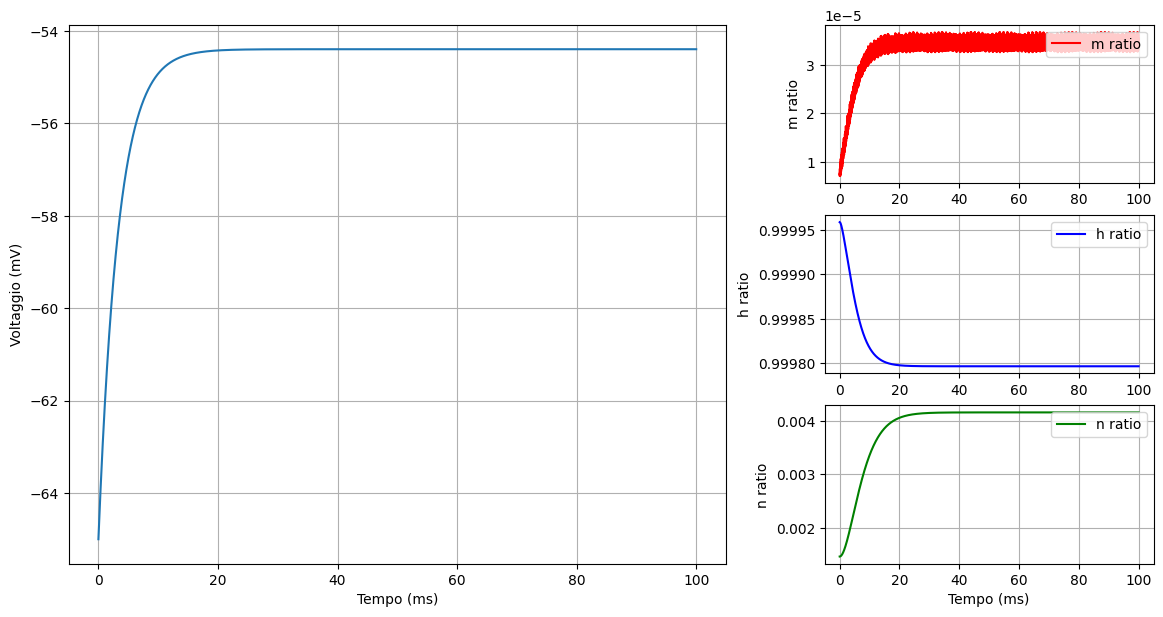

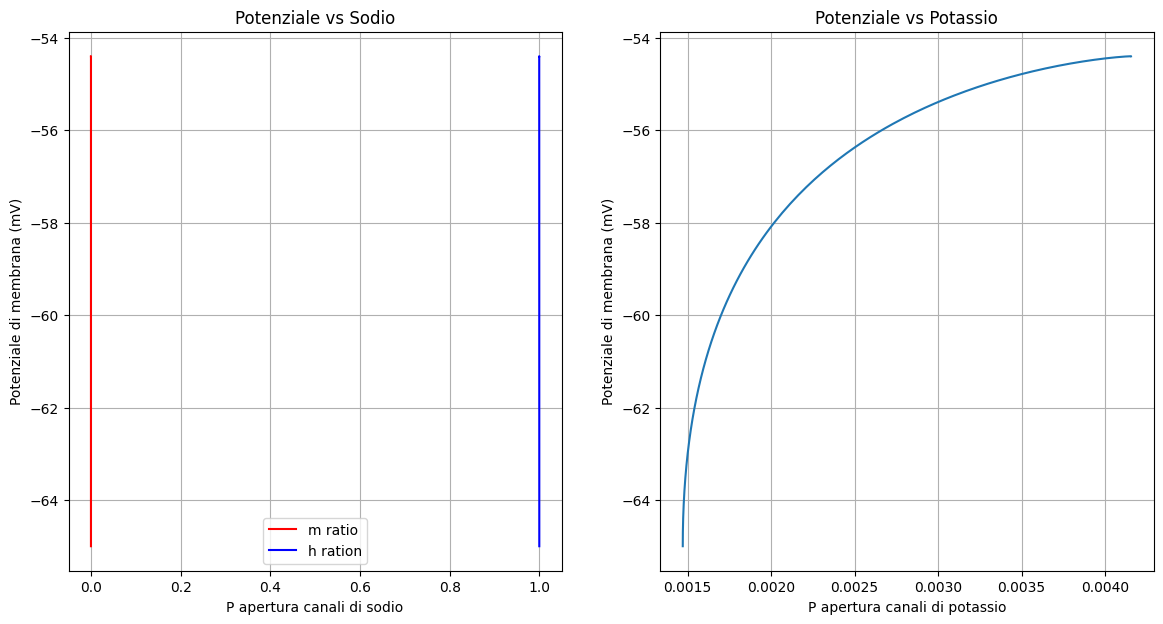

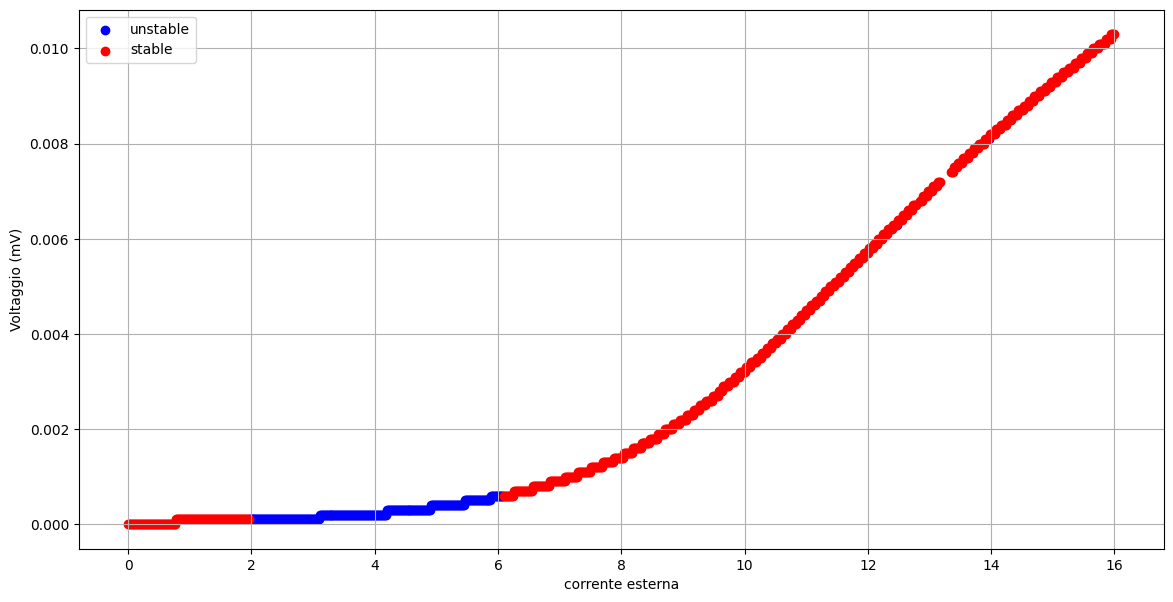

In [163]:
Cm = 1
Gna = 120
Gk = 120
Gl = 0.3
ENa = 50
Ek = -77.0
El = -54.4
Ie = 0
V0 = -65.0
T = 1000
n_p = 10000

time_plots(100,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
equilibrium_plot_V_Ie(-65.0,Cm,Gna,ENa,Gk,Ek,Gl,El,np.linspace(0,16,1000))

# Subthreshold Response #
Descrizione: Piccole depolarizzazioni del potenziale di membrana che non superano la soglia di attivazione.       
Correnti dominanti: Le correnti passive (e.g., perdite) e una leggera attivazione delle correnti di sodio.     
Condizioni: Stimoli esterni (Ie) che non sono sufficientemente forti per generare un potenziale d'azione.          
Dinamica: Il neurone ritorna al potenziale di riposo senza attività significativa.      


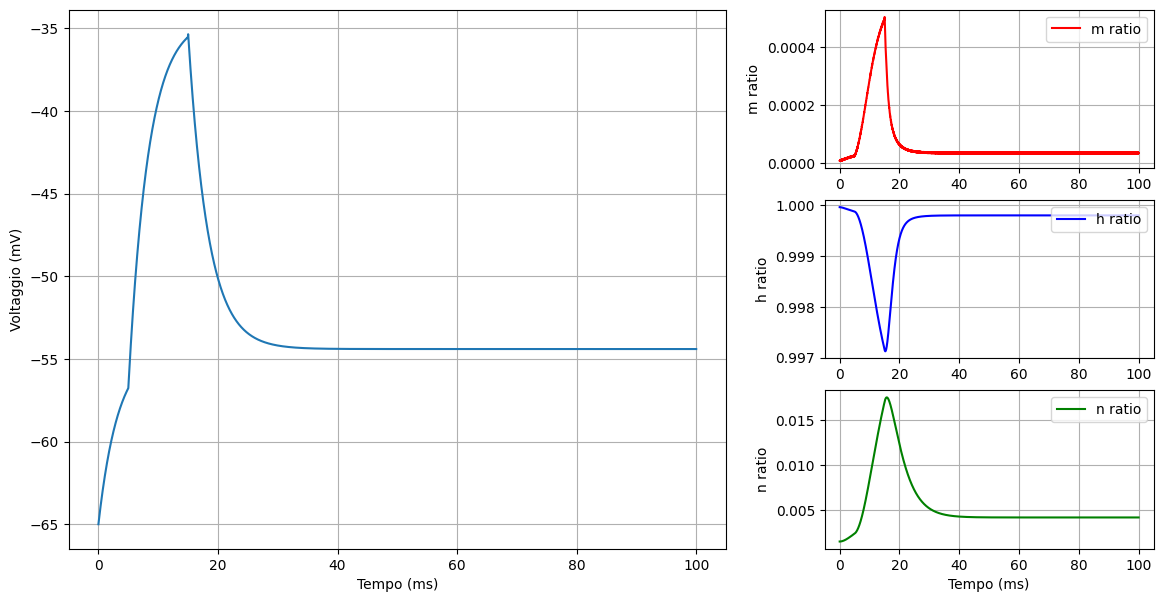

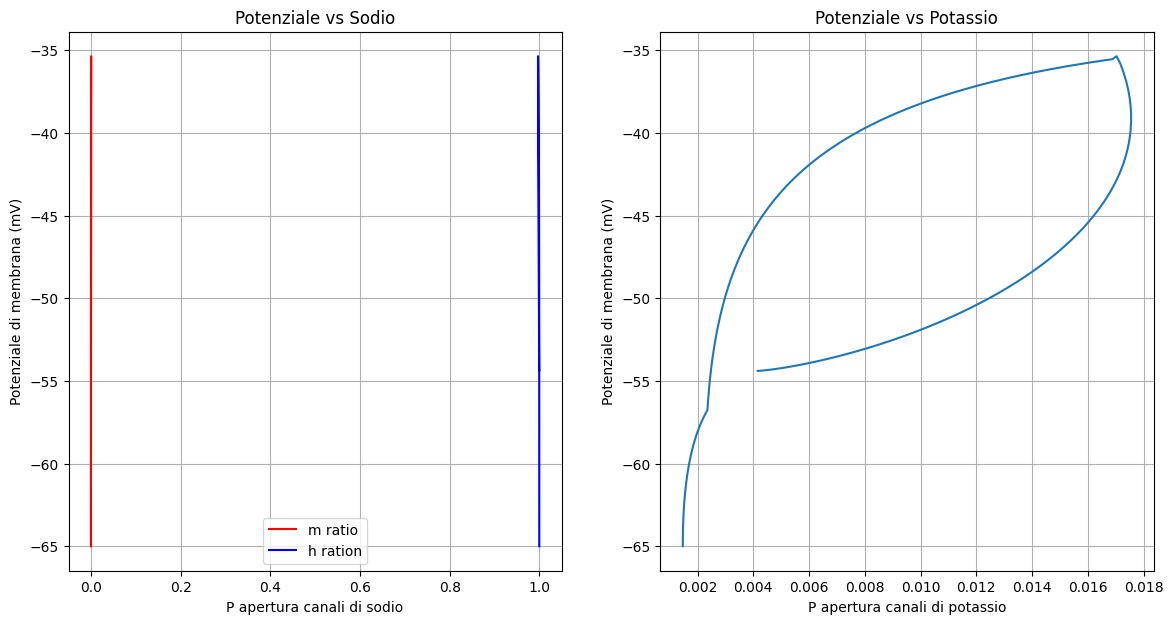

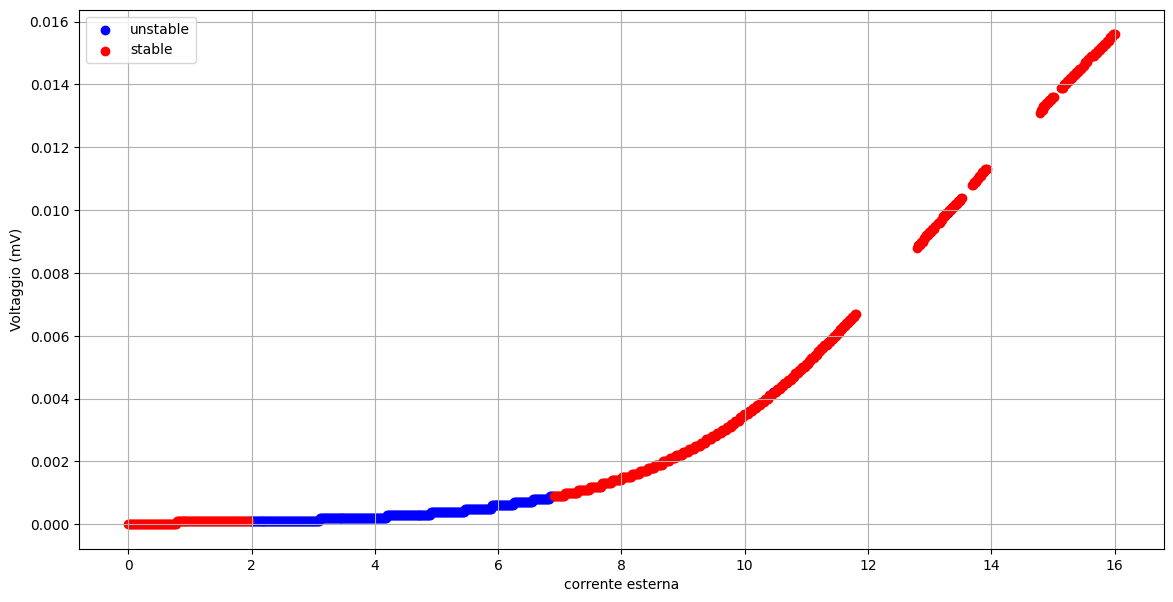

In [167]:
Cm = 1
Gna = 120
Gk = 36
Gl = 0.3
ENa = 50
Ek = -77
El = -54.4
Ie = [(6,5,10)]
V0 = -65.0
T = 1000
n_p = 10000

time_plots(100,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
equilibrium_plot_V_Ie(-65.0,Cm,Gna,ENa,Gk,Ek,Gl,El,np.linspace(0,16,1000))

# Spiking #
Descrizione: Se lo stimolo esterno (Ie) supera una soglia critica, il neurone genera un potenziale d’azione.       
Fasi del potenziale d’azione:                                                                                           
    Depolarizzazione rapida: Apertura dei canali del sodio (m aumenta), con un forte flusso di Na+ verso l'interno.        
    Ripolarizzazione: Apertura dei canali del potassio (n aumenta) e inattivazione dei canali del sodio (h diminuisce).       
    Iperpolarizzazione: Il potenziale scende al di sotto del potenziale di riposo per breve tempo.          
Correnti dominanti: Transizioni rapide tra INa (sodio) e IK (potassio).          
Condizioni: Stimoli esterni (Ie) sufficienti a superare la soglia         

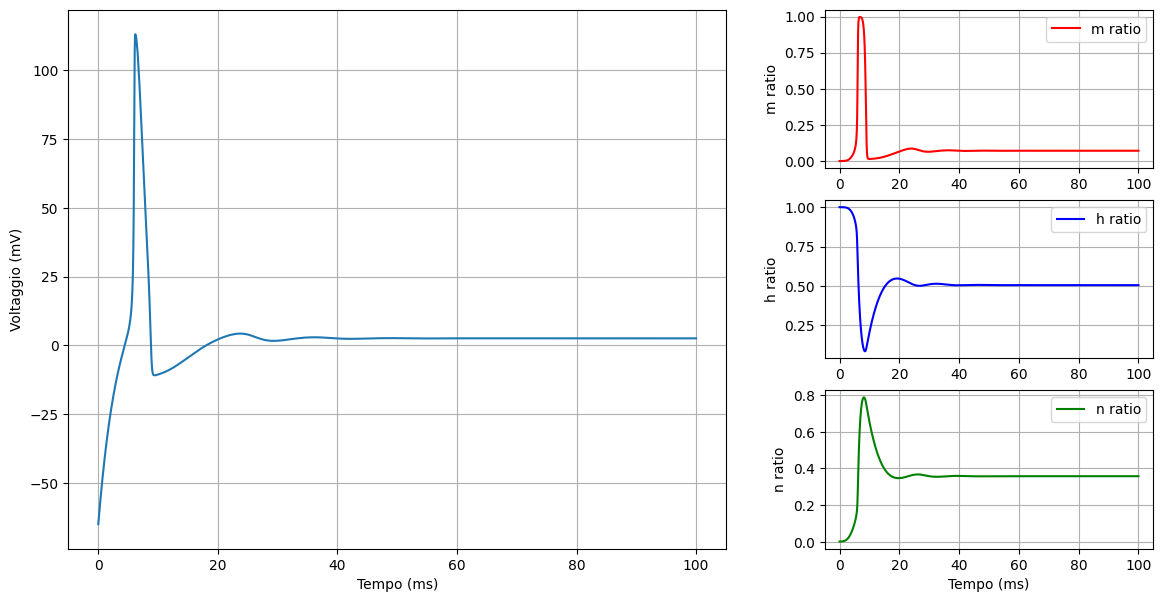

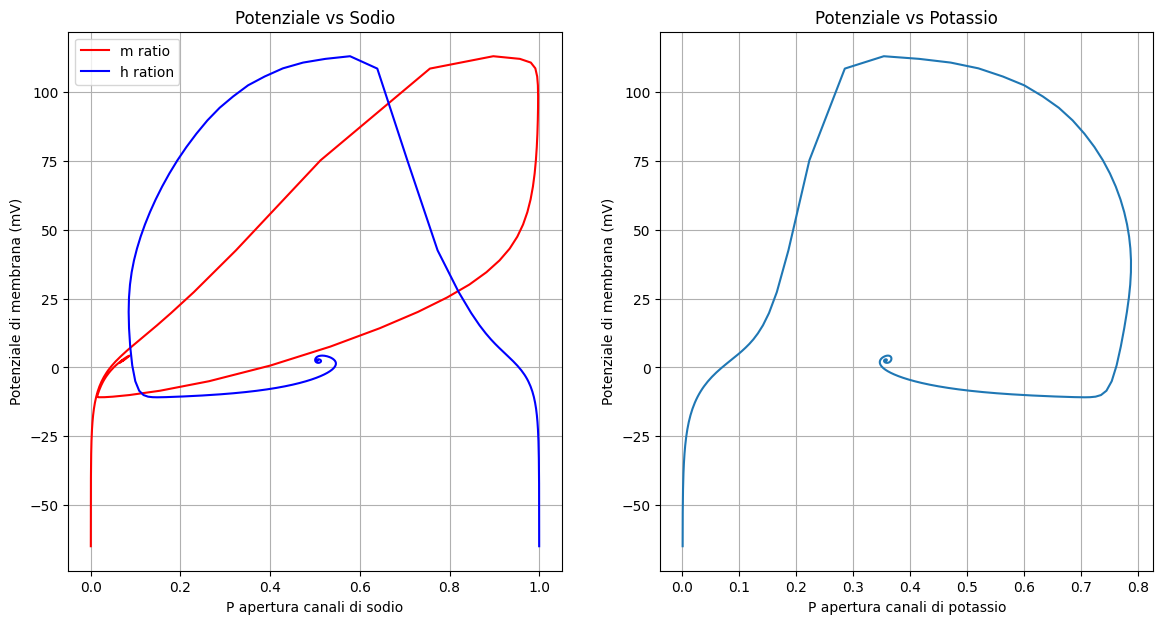

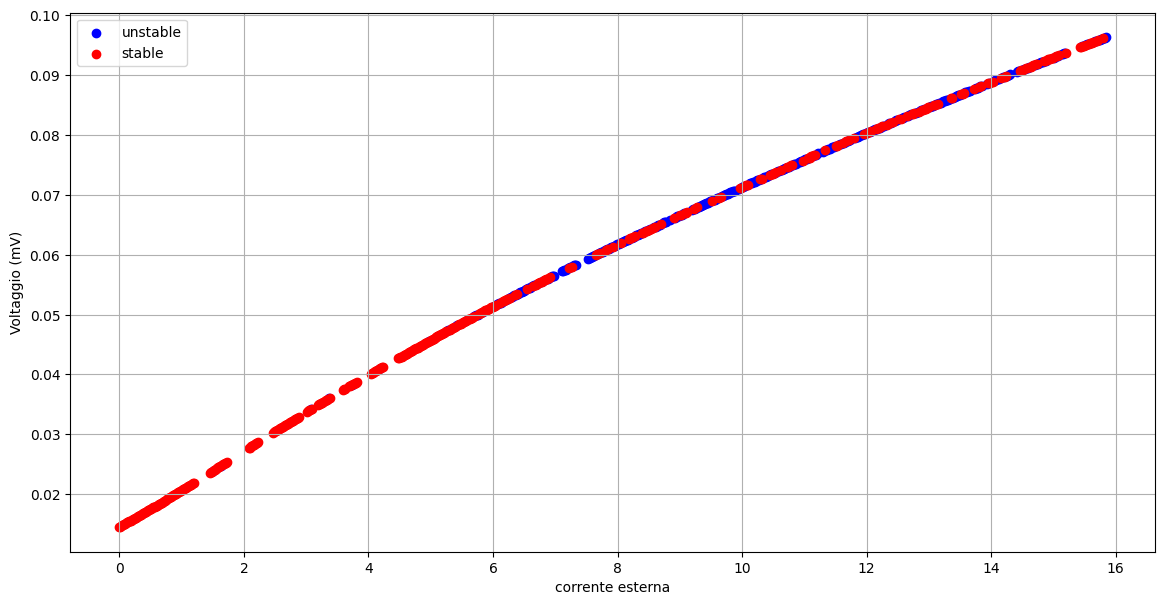

In [192]:
Cm = 1
Gna = 120
Gk = 36
Gl = 0.3
ENa = 115
Ek = -12
El = -10.4
Ie = 10
V0 = -65.0
T = 1000
n_p = 10000

time_plots(100,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
equilibrium_plot_V_Ie(-65.0,Cm,Gna,ENa,Gk,Ek,Gl,El,np.linspace(0,16,1000))

# Regular Spiking #
Descrizione: Con uno stimolo continuo sopra la soglia, il neurone produce una serie di potenziali d’azione con una frequenza regolare.       
Dinamica: La frequenza aumenta all’aumentare della corrente esterna (Ie).         
Condizioni: Corrente costante di intensità moderata-alta.         
Ruolo funzionale: Trasmissione di segnali persistenti.      

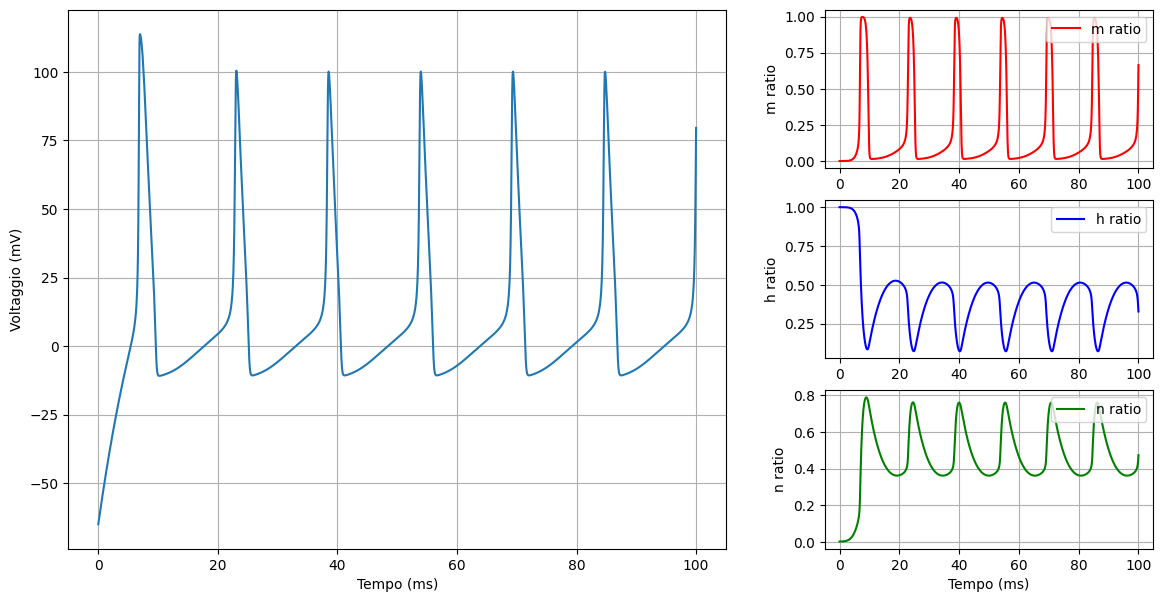

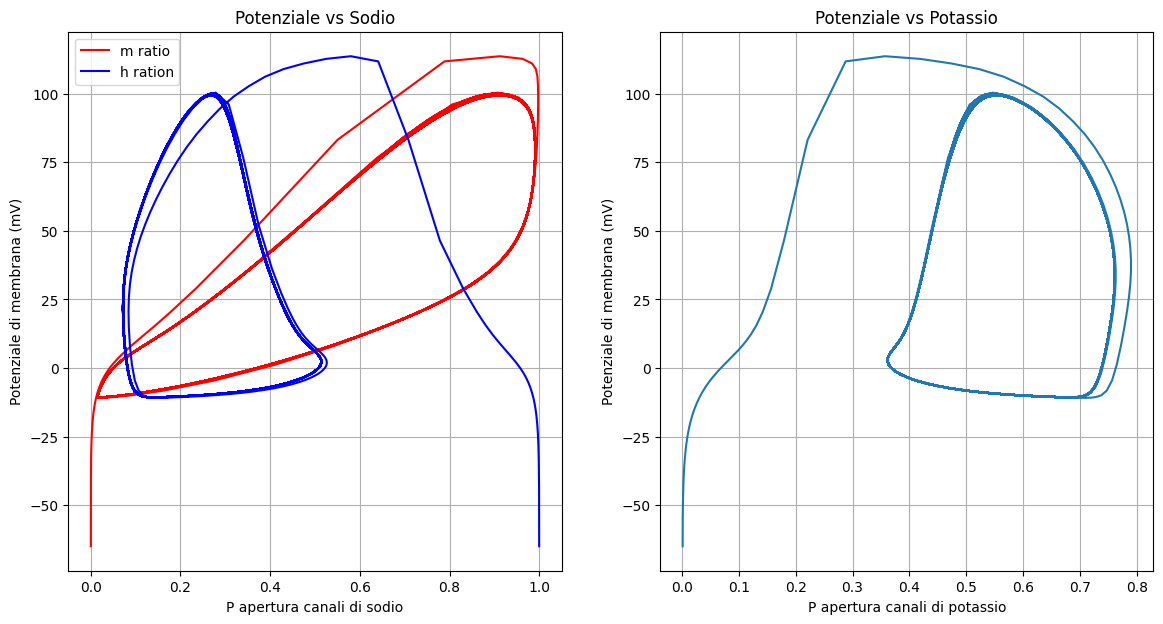

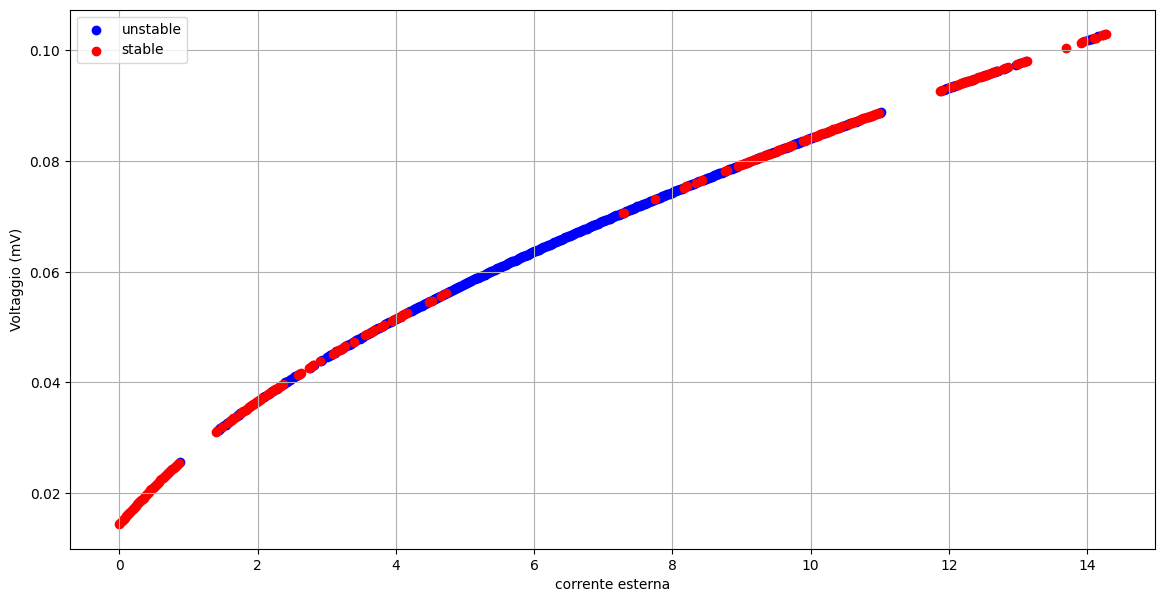

In [202]:
Cm = 1
Gna = 120
Gk = 36
Gl = 0.1
ENa = 115
Ek = -12
El = -10.4
Ie = 10
V0 = -65.0
T = 1000
n_p = 10000

time_plots(100,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,ENa,Ek,El,Ie)
equilibrium_plot_V_Ie(-65.0,Cm,Gna,ENa,Gk,Ek,Gl,El,np.linspace(0,16,1000))

# Quiescence #
Descrizione: Il neurone non è eccitabile, rimanendo costantemente vicino al potenziale di riposo, senza generare attività.       
Correnti dominanti: Correnti passive bilanciate.        
Condizioni: Mancanza di stimoli o forte iperpolarizzazione.          

# Bursting #
Descrizione: Attività in cui il neurone genera brevi raffiche di potenziali d’azione seguite da periodi di silenzio.                             
Correnti dominanti: Può dipendere da una combinazione di INa, IK e correnti lente (come ICa nel caso di estensioni del modello Hodgkin-Huxley).              
Condizioni: Stimoli variabili o dinamiche interne al neurone.                
Ruolo funzionale: Segnali più complessi utilizzati, ad esempio, in reti neurali per funzioni motorie o cognitive.

# Limit Cycles #
Descrizione: Il potenziale di membrana oscilla in modo periodico tra due valori, come un ciclo limite stabile.           
Correnti dominanti: Equilibrio dinamico tra INa e IK, che guida le oscillazioni.                                          
Condizioni: Tipico nelle biforcazioni Hopf o nelle reti neurali che favoriscono ritmi periodici (e.g., ritmi cerebrali).            

# Comportamento Caotico #
Descrizione: In specifiche condizioni (ad esempio, modifiche nei parametri del sistema), il neurone può mostrare dinamiche caotiche.       
Correnti dominanti: Interazione complessa tra tutte le correnti ioniche.           
Condizioni: Può verificarsi in modelli estesi o con stimoli irregolari.                  
Ruolo funzionale: Potenziale per spiegare attività neurale complessa e imprevedibile.        